# Jena Climate – Single‑Step Temperature Forecasting with LSTM
This notebook builds an LSTM model that predicts the temperature 1 hour ahead (i.e. 6 time‑steps) based on past climate sensor readings recorded at the Max Planck Institute for Biogeochemistry in Jena.

## 1. Imports & Download

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import keras, pathlib, urllib, zipfile

2025-04-29 02:07:11.022357: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 02:07:11.029011: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 02:07:11.080092: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 02:07:11.122723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745892431.164023    1970 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745892431.17

## 2. Retrieve dataset

In [ ]:
data_dir  = pathlib.Path("data/jena_climate")
data_dir.mkdir(exist_ok=True)
csv_path  = data_dir / "jena_climate_2009_2016.csv"
zip_path  = data_dir / "jena_climate_2009_2016.csv.zip"

# file download if not csv_path.exists():
if not csv_path.exists():
    if not zip_path.exists():
        url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
        print("Downloading Jena Climate dataset …")
        keras.utils.get_file(origin=url, fname=zip_path.name, cache_dir=".", cache_subdir=str(data_dir))
    print("Extracting", zip_path)
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(data_dir)
    zip_path.unlink()

# CSV load
df = pd.read_csv(csv_path)
print("Loaded:", csv_path, "→ shape:", df.shape)


Loaded: data/jena_climate/jena_climate_2009_2016.csv → shape: (420551, 15)


## 2-1 Jena_climate dataset visualization

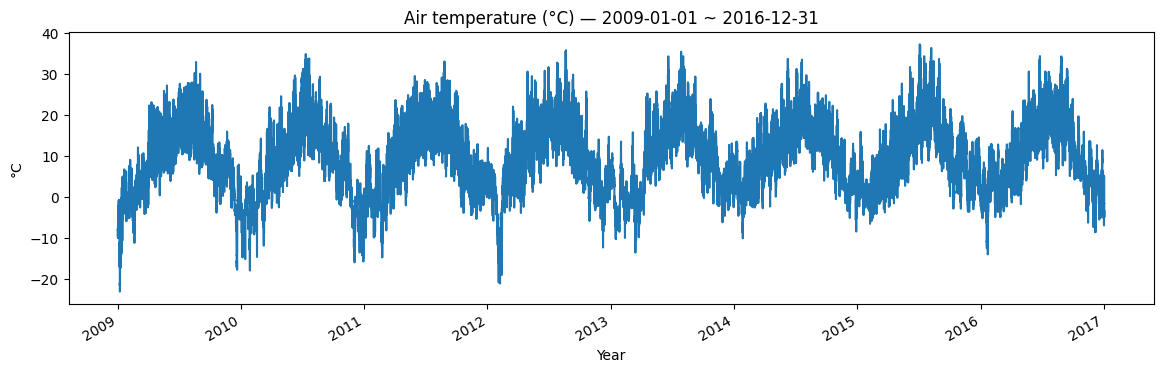

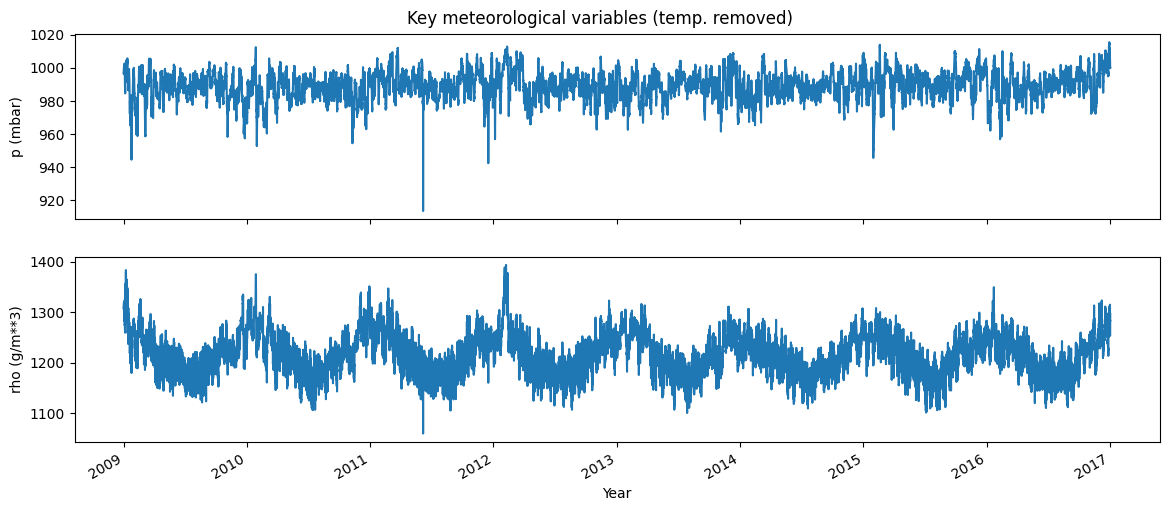

In [3]:
# 2-1  Jena_climate dataset visualization
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

# ────────────────────────────────────────────────────────────────
# 1) 데이터 적재 (이미 앞 셀에서 csv_path 변수가 만들어져 있다고 가정)
#    만약 csv_path 가 없다면: csv_path = Path("data/jena_climate/jena_climate_2009_2016.csv")
# ────────────────────────────────────────────────────────────────
df = pd.read_csv(csv_path)

# @ Note: 원본에는 "Date Time" 열이 별도 문자열이므로,
#         시각화 편의상 datetime index 로 변환합니다.
df["Date Time"] = pd.to_datetime(df["Date Time"], format="%d.%m.%Y %H:%M:%S")
df = df.set_index("Date Time")

# ────────────────────────────────────────────────────────────────
# 2) (1) 전체 기간 온도 추세 plot
# ────────────────────────────────────────────────────────────────
plt.figure(figsize=(14, 4))
plt.plot(df.index, df["T (degC)"])
plt.title("Air temperature (°C) — 2009-01-01 ~ 2016-12-31")
plt.ylabel("°C")
plt.xlabel("Year")
plt.gcf().autofmt_xdate()
plt.show()

# ────────────────────────────────────────────────────────────────

vars_to_plot = ["p (mbar)",          # 대기압
                "rho (g/m**3)"]      # 공기밀도
# "T (degC)", # 온도는 이미 위에서 그렸으므로 제외

fig, axes = plt.subplots(len(vars_to_plot), 1,
                         figsize=(14, 6), sharex=True)

for ax, col in zip(axes, vars_to_plot):
    ax.plot(df.index, df[col])
    ax.set_ylabel(col)

axes[-1].set_xlabel("Year")
fig.suptitle("Key meteorological variables (temp. removed)", y=0.92)
fig.autofmt_xdate()
plt.show()


## 3. Normalise

In [4]:
n = len(df)
train_df = df.iloc[:int(n*0.7)]
stats = train_df.describe().transpose()

eps = 1e-6
stats['std'] = stats['std'].replace(0, eps)   # avoid div by zero
df_norm = (df - stats['mean']) / stats['std']

# sanity check
values = df_norm.to_numpy(dtype=np.float32)   # ← dtype 강제
assert np.isfinite(values).all(), "NaN/Inf present after normalisation!"

## 4. Build windowed datasets

In [5]:
past_len, future_len = 72, 6
batch_size = 256

def make_ds(data):
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=data[:,0],
        sequence_length=past_len + future_len,
        sequence_stride=1,
        shuffle=True,
        batch_size=batch_size
    )
    ds = ds.map(lambda x,y:(x[:,:past_len,:],
                            tf.expand_dims(x[:,past_len+future_len-1,0],-1)))
    return ds

train_ds = make_ds(values[:int(n*0.7)])
val_ds   = make_ds(values[int(n*0.7):int(n*0.9)])
test_ds  = make_ds(values[int(n*0.9):])

# check one batch
bx, by = next(iter(train_ds))
tf.debugging.assert_all_finite(bx,"bad bx")
tf.debugging.assert_all_finite(by,"bad by")
print("Batch OK:", bx.shape, by.shape)


2025-04-29 02:07:27.367830: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Batch OK: (256, 72, 14) (256, 1)


## 5. Define LSTM model

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(past_len, df.shape[1])),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
opt = tf.keras.optimizers.Adam(1e-4, clipnorm=1.0)
model.compile(opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 72, 64)         │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,185 (129.63 KB)

 Trainable params: 33,185 (129.63 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Train

In [7]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.TerminateOnNaN()
]

history = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/5
 120/1150 ━━━━━━━━━━━━━━━━━━━━ 1:02 61ms/step - loss: 1.1327 - root_mean_squared_error: 1.0636

KeyboardInterrupt: 

## 7. Evaluate & inverse transform example predictions

In [10]:

test_rmse = model.evaluate(test_ds, verbose=0)[1]
print(f"Test RMSE (normalised): {test_rmse:.3f}")

temp_mean, temp_std = stats.loc['T (degC)', ['mean','std']]
for bx, by in test_ds.take(1):
    preds = model.predict(bx)
    print("\nPred  | True (°C)")
    for p,t in zip(preds[:10], by[:10]):
        print(f"{p[0]*temp_std+temp_mean:6.2f} | {t[0]*temp_std+temp_mean:6.2f}")


Test RMSE (normalised): 0.718
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Pred  | True (°C)
 16.50 |  26.62
 11.54 |   7.27
 11.34 |  10.63
 14.65 |  13.43
 15.32 |  16.53
 10.72 |   8.28
 10.88 |   9.31
 11.28 |   8.25
 12.39 |  12.63
 10.33 |   4.99


## 8. Model Save & Load Model 

In [ ]:
!mkdir -p model_/
!chmod +rw model_/
model_dir = "model_/jena_climate_model.h5"
model.save(model_dir)
# Load the model
loaded_model = tf.keras.models.load_model(model_dir)
# Check the loaded model
loaded_model.summary()
